In [61]:
from utils import *
from prune import *

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

import torch
import torch.utils
import torch.nn as nn
import torch.optim as optim

import torchvision

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

GeForce GTX 1660 SUPER


In [63]:
batch_size = 64

mnist_train, mnist_test = loadMnist(batch_size)
cifar_train, cifar_test = loadCifar(batch_size)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


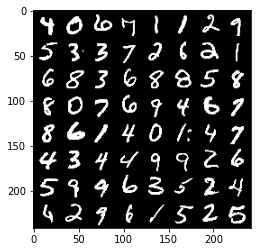

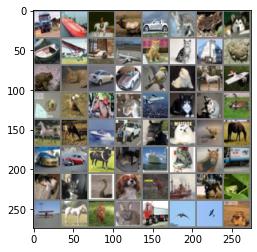

In [64]:
def imshow(img, norm=True):
    if norm:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter1 = iter(mnist_train)
images1, labels1 = dataiter1.next()

# show images
imshow(torchvision.utils.make_grid(images1), False)


# get some random training images
dataiter2 = iter(cifar_train)
images2, labels2 = dataiter2.next()

# show images
imshow(torchvision.utils.make_grid(images2))

In [65]:
import lenet
import convnet

In [149]:
iterationDict = None
accDict = None

train_set = cifar_train
test_set = cifar_test
lr = 3e-4

fcPruneAmount = 0.1676
convPruneAmount = 0.10

pruneType = "reset"
version = "global"

for i in range(25):
    print(i)

    model = convnet.Conv6().to(device)
    model = initOrig(model)

    weights = getOrigWeights(model)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    # iCount = 0

    if iterationDict == None:
        iterationDict = loadIterDict(model.__class__.__name__, pruneType, version)
        accDict = loadAccDict(model.__class__.__name__, pruneType, version)

    while getPruneAmount(model) < 0.95:

        model = rewindOrigWeights(model, weights)
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
        model, optimizer, losses, iterCount, acc = training_complete_iter(model, criterion, optimizer, train_set, test_set, device)
        
        # if getPruneAmount(model) == 0.0:
        #     model, optimizer, losses, iterCount, acc = training_complete_iter(model, criterion, optimizer, train_set, test_set, device)
        # else:
        #     model, optimizer, losses, iterCount, acc = training_complete_iter(model, criterion, optimizer, train_set, test_set, device, train_for=50)

        key = '{:.3f}'.format(getPruneAmount(model).item())
        # iCount += iterCount

        if key not in iterationDict:
            iterationDict[key] = []
            accDict[key] = []
        iterationDict[key].append(iterCount)
        accDict[key].append(acc)

        saveIterDict(iterationDict, model.__class__.__name__, pruneType, version)
        saveAccDict(accDict, model.__class__.__name__, pruneType, version)

        model = applyPrune(model, nn.Linear, fcPruneAmount, prune_model_universal_unstructured)
        # model = applyPrune(model, nn.Conv2d, convPruneAmount, prune_model_l1_unstructured)

    print('\n')

0
I:6.3k P:0.000	Train loss: 0.0318	Valid loss: 0.6161	Valid acc: 79.78        
Training took: 7300 iterations	Min loss at: 6300
I:6.4k P:0.167	Train loss: 0.0470	Valid loss: 0.6426	Valid acc: 78.71        
Training took: 6500 iterations	Min loss at: 6400
I:5.7k P:0.307	Train loss: 0.0254	Valid loss: 0.6204	Valid acc: 78.04        
Training took: 9300 iterations	Min loss at: 5700
I:5.9k P:0.423	Train loss: 0.0297	Valid loss: 0.6226	Valid acc: 78.14        
Training took: 8900 iterations	Min loss at: 5900
I:5.9k P:0.519	Train loss: 0.0313	Valid loss: 0.6186	Valid acc: 78.03        
Training took: 8300 iterations	Min loss at: 5900
I:4.5k P:0.600	Train loss: 0.0411	Valid loss: 0.6098	Valid acc: 78.48        
Training took: 5800 iterations	Min loss at: 4500
I:3.8k P:0.667	Train loss: 0.0315	Valid loss: 0.6530	Valid acc: 78.30        
Training took: 7200 iterations	Min loss at: 3800
I:6.4k P:0.723	Train loss: 0.0291	Valid loss: 0.6441	Valid acc: 78.58        
Training took: 8000 iterations	

KeyboardInterrupt: 

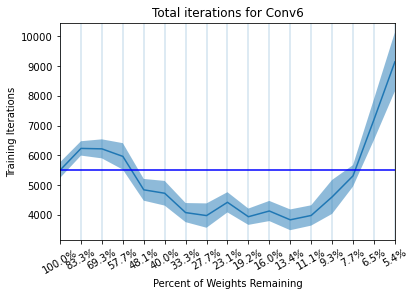

In [150]:
backupIter = copy.deepcopy(iterationDict)

for k, v in iterationDict.items():
    iterationDict[k] = list(filter(lambda x: x > 0, iterationDict[k]))

X = list(map(float, iterationDict.keys()))
Y = list(map(average, iterationDict.values()))
data = list(iterationDict.values())

interval = list(map(lambda x: st.t.interval(alpha=0.9, df=len(x)-1, loc=np.mean(x), scale=st.sem(x)), data))
interval = np.array([*interval])

axes = plt.gca()
plt.plot(Y)
plt.fill_between(list(range(len(X))), interval[:, 0], interval[:, 1], alpha=.5)
plt.xlabel("Percent of Weights Remaining")
plt.ylabel("Training Iterations")
plt.title(f"Total iterations for {model.__class__.__name__}")
plt.xlim([0, 1])
plt.xticks(ticks=list(range(len(X))), labels=list(map(lambda x: f'{100 * (1 - x):.1f}%', X)), rotation=30)
plt.axhline(y=Y[0], color='b', linestyle='-')
plt.ylim(axes.get_ylim())
plt.vlines(list(range(len(X))), axes.get_ylim()[0], axes.get_ylim()[1], alpha=0.2)

if version == None:
    plt.savefig(f'./results/{model.__class__.__name__}/{pruneType}/iter.png')
else:
    plt.savefig(f'./results/{model.__class__.__name__}/{pruneType}/iter_{version}.png')

print()

In [151]:
for k, v in accDict.items():
    for i in range(len(v)):
        try:
            accDict[k][i] = accDict[k][i].item()
        except:
            pass

backupAcc = copy.deepcopy(accDict)

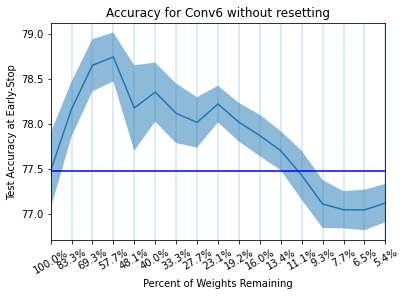

In [152]:
X = list(map(float, accDict.keys()))
Y = list(map(average, accDict.values()))
data = list(accDict.values())

interval = list(map(lambda x: st.t.interval(alpha=0.9, df=len(x)-1, loc=np.mean(x), scale=st.sem(x)), data))
interval = np.array([*interval])

axes = plt.gca()
plt.plot(Y)
plt.fill_between(list(range(len(X))), interval[:, 0], interval[:, 1], alpha=.5)
plt.xlabel("Percent of Weights Remaining")
plt.ylabel("Test Accuracy at Early-Stop")
plt.title(f"Accuracy for {model.__class__.__name__} without resetting")
plt.xlim([0, 1])
plt.xticks(ticks=list(range(len(X))), labels=list(map(lambda x: f'{100 * (1 - x):.1f}%', X)), rotation=30)
plt.axhline(y=Y[0], color='b', linestyle='-')
plt.ylim(axes.get_ylim())
plt.vlines(list(range(len(X))), axes.get_ylim()[0], axes.get_ylim()[1], alpha=0.2)


if version == None:
    plt.savefig(f'./results/{model.__class__.__name__}/{pruneType}/acc.png')
else:
    plt.savefig(f'./results/{model.__class__.__name__}/{pruneType}/acc_{version}.png')
